Some imports

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import pickle
from impartial_text_cls.impartial_text_cls import ImpartialTextClassifier
import tensorflow as tf
import tensorflow_hub as tfhub

Uncomment and run, if you don't have checkpoint downloaded

In [2]:
# tfhub.Module('https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1')

Load the data

In [3]:
df = pd.read_csv('data/preprocessed.csv')
df.head()

,Unnamed: 0,preprocessed_text,sentiment
0,0,теперь я знаю чего хочу на нг:dd ^^,1
1,1,скоро матч робин-локо болею сегодня за рубин н...,1
2,2,перестаньте а (,0
3,3,матвейка милааааш^^ соскучилась по нему),1
4,4,блиин:с я и на концеерт хочу теперь:((((( а т...,0


Train/test split

In [4]:
text_train, text_test, label_train, label_test = train_test_split(
    df['preprocessed_text'],
    df['sentiment'],
    test_size=0.3,
    shuffle=True,
    random_state=42
)

Training

In [5]:
cls = ImpartialTextClassifier(
    bert_hub_module_handle='/tmp/tfhub_modules/2e9b4b015e19c732663e0684f163c86f1deeee30/',
    filters_for_conv2=25, 
    filters_for_conv3=25, 
    filters_for_conv4=25, 
    filters_for_conv5=25,
    hidden_layer_size=150, 
    n_hidden_layers=2, 
    batch_size=16, 
    num_monte_carlo=10,
    bayesian=True, 
    multioutput=False, 
    random_seed=42, 
    validation_fraction=0.15,
    max_epochs=100, 
    patience=5, 
    verbose=True, 
    kl_weight_init=0.5, 
    kl_weight_fin=1e-2
)
cls.fit(list(text_train)[:2000], list(label_train)[:2000])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Maximal length of text (in BPE): 128
Mean length of text (in BPE): 25.99705882352941
Median length of text (in BPE): 24

Number of known texts for training is 1700.
Number of known texts for validation is 300.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
The BERT model has been loaded from the TF-Hub.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `layer.add_weight` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Epoch 0
  Duration is 664.871 seconds
  KL 

ImpartialTextClassifier(batch_size=16, bayesian=True,
                        bert_hub_module_handle='/tmp/tfhub_modules/2e9b4b015e19c732663e0684f163c86f1deeee30/',
                        filters_for_conv1=100, filters_for_conv2=25,
                        filters_for_conv3=25, filters_for_conv4=25,
                        filters_for_conv5=25, gpu_memory_frac=1.0,
                        hidden_layer_size=150, kl_weight_fin=0.01,
                        kl_weight_init=0.5, max_epochs=100, multioutput=False,
                        n_hidden_layers=2, num_monte_carlo=10, patience=5,
                        random_seed=42, validation_fraction=0.15, verbose=True)

Sample size against inference time (in sec)

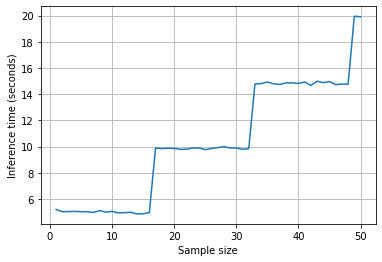

In [6]:
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt
%matplotlib inline

sample_sizes = []
inference_times = []
for i in range(50):
    start_time = time.time()
    cls.predict(list(text_test)[:(i + 1)])
    end_time = time.time()
    sample_sizes.append(i + 1)
    inference_times.append(end_time - start_time)
plt.plot(sample_sizes, inference_times)
plt.xlabel('Sample size')
plt.ylabel('Inference time (seconds)')
plt.grid()

As we can see, model is pretty slow on inference. Let's see what happens on small fraction of test data (first 2000 test sentences)

In [7]:
start_time = time.time()
y_pred = cls.predict(list(text_test)[:2000])
end_time = time.time()
print('Inference time: {} seconds'.format(end_time - start_time))
print(classification_report(list(label_test)[:2000], y_pred))

Inference time: 618.5718190670013 seconds
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.98      0.95      0.97       983
           1       0.96      0.98      0.97      1017

    accuracy                           0.97      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.97      0.97      0.97      2000



/home/rdalex/venv3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Saved the model

In [8]:
with open('trained_models/bert_bayesian.pkl', 'wb') as fp:
    pickle.dump(cls, fp)